# Unit 5 - Financial Planning

In [192]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [108]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [95]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [96]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [97]:
# Fetch current BTC price
btc_value_data = requests.get(btc_url).json()
btc_value = float(btc_value_data['data']['1']['quotes']['USD']['price'])

# Fetch current ETH price
eth_value_data = requests.get(eth_url).json()
eth_value = float(eth_value_data["data"]["1027"]["quotes"]["USD"]["price"])

# Compute current value of my crpto
my_btc_value = my_btc * btc_value
my_eth_value = my_eth * eth_value
 
# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $21247.64
The current value of your 5.3 ETH is $6832.39


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [100]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [109]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [125]:
# Format current date as ISO format
current_date = pd.Timestamp("2022-12-13", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
ticker_data = api.get_bars(
    tickers,
    timeframe,
    start = current_date,
    end = current_date
).df

ticker_data
# Reorganize the DataFrame
# Separate ticker data
AGG = ticker_data[ticker_data["symbol"]=='AGG'].drop('symbol', axis=1)
SPY = ticker_data[ticker_data["symbol"]=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
ticker_df = pd.concat([AGG, SPY], axis=1, keys=["AGG", "SPY"])

# Preview DataFrame
ticker_df

AGG                                            \
                             open    high   low  close   volume trade_count   
timestamp                                                                     
2022-12-13 05:00:00+00:00  100.18  100.18  99.4  99.47  9084743       32368   

                                         SPY                          \
                                vwap    open    high     low   close   
timestamp                                                              
2022-12-13 05:00:00+00:00  99.635621  410.22  410.49  399.07  401.97   

                                                              
                              volume trade_count        vwap  
timestamp                                                     
2022-12-13 05:00:00+00:00  123026229      887537  403.567729

In [132]:
# Pick AGG and SPY close prices
agg_close_price = float(ticker_df["AGG"]["close"])
spy_close_price = float(ticker_df["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $99.47
Current SPY closing price: $401.97


In [143]:
# Compute the current value of shares
my_agg_value = float(my_agg * agg_close_price)
my_spy_value = float(my_spy * spy_close_price)

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $20098.50
The current value of your 200 AGG shares is $19894.00


### Savings Health Analysis

In [162]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
total_crypto = my_btc_value + my_eth_value
total_shares = my_agg_value + my_spy_value
financial_assets = {
    'amount':[total_crypto, total_shares],
    'assets':["crypto", "shares"]}

# Create savings DataFrame
df_savings = pd.DataFrame(financial_assets).set_index("assets")
    

# Display savings DataFrame
display(df_savings)

,amount
assets,
crypto,28080.033
shares,39992.500


<AxesSubplot:title={'center':'Asset Portfolio Composition'}, ylabel='amount'>

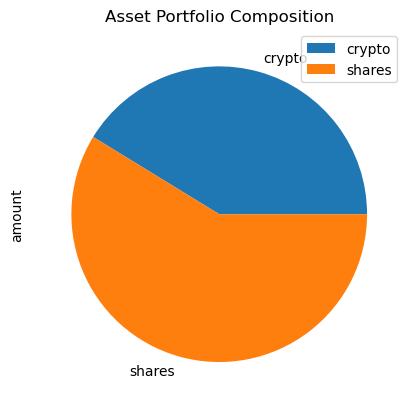

In [172]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title = "Asset Portfolio Composition")

In [177]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings["amount"].sum()

# Validate saving health
if total_savings > emergency_fund:
    print(f"Congraulations for having enough money in this fund.")
elif total_savings == emergency_fund:
    print(f"Congraulations on reaching financial goal.")
else: 
    print(f"You're $ {emergency_fund - total_savings} from reaching financial goal.")

Congraulations for having enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [179]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [202]:
# Get 5 years' worth of historical data for SPY and AGG
df_stock_data = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
).df

# Reorganize the DataFrame
# Separate ticker data

AGG = df_stock_data[df_stock_data["symbol"]=='AGG'].drop('symbol', axis=1).dropna()
SPY = df_stock_data[df_stock_data["symbol"]=='SPY'].drop('symbol', axis=1).dropna()

# Concatenate the ticker DataFrames
df_stock_data= pd.concat([AGG, SPY], axis=1, keys=["AGG", "SPY"])

# Display sample data
df_stock_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2016-05-02 04:00:00+00:00       15119  110.627199  206.92  208.18  206.41   
2016-05-03 04:00:00+00:00       15662  110.865995  206.52  206.80  205.28   
2016-05-04 04:00:00+00:00       13982  110.879063  204.99  205.85  204.42   
2016-05-05 04:00:00+00:00       15707  111.028363  205.56  205.98  204.47   
2016-05-06 04:00:00+00:00       12697  111.031967  204.08  205.77  203.88   

                                                                        
                              close     volume trade_count        vwap  
timestamp                                                               
2016-05-02 04:00:00+00:00  207.9700   61908515      263580  207.294812  
2016-05-03 04:00:00+00:00  206.1592  106422142      377518  206.312060  
2016-05-04 04:00:00+00:00  205.0100   92199810      345261  205.090172  
2016-05-05 04:00:00+00:00  204.9700   67597222      280622  205.141555  
2016-05-06 04:00:00+00:00  205.7200   89131004      340335  204.937074

In [203]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
num_sims= 500

port_forecast = MCSimulation(
    portfolio_data = df_stock_data,
    num_simulation = num_sims,
    weights = [0.4, 0.6],
    num_trading_days = (252*30)
)
    

In [209]:
# Printing the simulation input data
port_forecast.portfolio_data.head()

AGG                                        \
                             open      high       low    close   volume   
timestamp                                                                 
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.605  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.810  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.860  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.140  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.970  2718710   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2016-05-02 04:00:00+00:00       15119  110.627199          NaN  206.92   
2016-05-03 04:00:00+00:00       15662  110.865995     0.001853  206.52   
2016-05-04 04:00:00+00:00       13982  110.879063     0.000451  204.99   
2016-05-05 04:00:00+00:00       15707  111.028363     0.002526  205.56   
2016-05-06 04:00:00+00:00       12697  111.031967    -0.001530  204.08   

                                                                            \
                             high     low     close     volume trade_count   
timestamp                                                                    
2016-05-02 04:00:00+00:00  208.18  206.41  207.9700   61908515      263580   
2016-05-03 04:00:00+00:00  206.80  205.28  206.1592  106422142      377518   
2016-05-04 04:00:00+00:00  205.85  204.42  205.0100   92199810      345261   
2016-05-05 04:00:00+00:00  205.98  204.47  204.9700   67597222      280622   
2016-05-06 04:00:00+00:00  205.77  203.88  205.7200   89131004      340335   

                                                    
                                 vwap daily_return  
timestamp                                           
2016-05-02 04:00:00+00:00  207.294812          NaN  
2016-05-03 04:00:00+00:00  206.312060    -0.008707  
2016-05-04 04:00:00+00:00  205.090172    -0.005574  
2016-05-05 04:00:00+00:00  205.141555    -0.000195  
2016-05-06 04:00:00+00:00  204.937074     0.003659

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
port_forecast.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.009035,1.019800,1.007274,0.993537,0.999989,1.006793,0.987234,0.991026,0.999287,0.989965,...,1.008802,0.990631,0.998367,0.996306,1.005638,0.999298,1.003740,0.995918,0.997987,0.987705
2,1.015749,1.016643,1.021442,0.987915,1.000572,1.007587,0.989688,0.995665,1.004104,0.985250,...,1.010723,0.982956,0.998577,0.981389,1.018035,1.000601,1.002730,0.980490,1.011566,0.984374
3,0.991994,1.011483,1.030600,0.997095,0.997604,1.005709,0.994743,0.997920,0.994627,0.997900,...,1.012315,0.989154,0.981850,0.971472,1.006515,1.002006,1.004207,0.984857,1.011721,0.987595
4,0.987360,1.008866,1.034499,1.000035,0.996255,1.003667,0.994341,0.979276,0.999065,0.996478,...,1.016074,0.968970,0.987125,0.972621,1.010508,1.005873,1.004374,0.987862,1.008460,1.000726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,15.161399,13.710953,7.014478,13.250531,17.253323,6.504709,17.273753,8.488013,10.957276,13.189109,...,8.223420,12.288181,12.515016,19.375254,10.173651,22.237832,29.862674,5.580458,13.105158,4.897044
7557,15.177512,13.738440,7.043751,13.102212,17.417942,6.477584,17.095762,8.496915,10.990621,12.939785,...,8.340971,12.323093,12.494097,19.483966,10.183564,22.458175,30.326832,5.621498,12.995128,4.964084
7558,15.330981,13.708830,7.038211,13.151718,17.470599,6.487290,16.977758,8.420851,10.888101,13.032973,...,8.363106,12.358473,12.505053,19.621043,10.328272,22.774489,30.055585,5.658289,13.078240,4.966424
7559,15.247704,13.672925,7.101012,13.252124,17.570481,6.403013,17.077302,8.521628,10.773828,12.927884,...,8.216022,12.349652,12.489294,19.596308,10.443810,22.852504,30.026844,5.669949,13.204933,4.931674


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

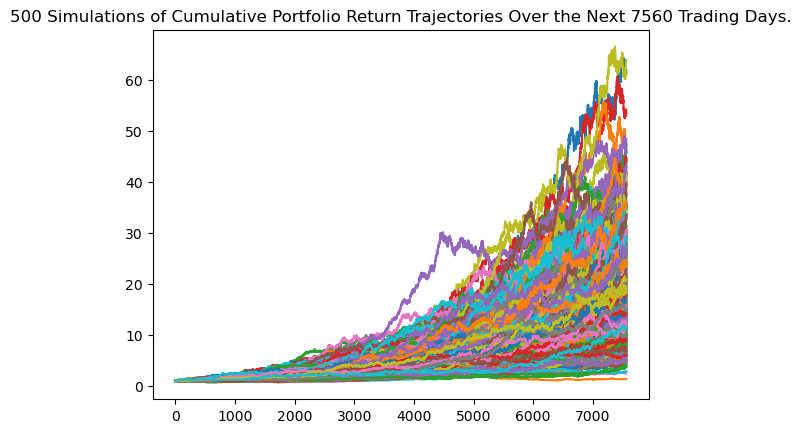

In [210]:
# Plot simulation outcomes
port_forecast.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

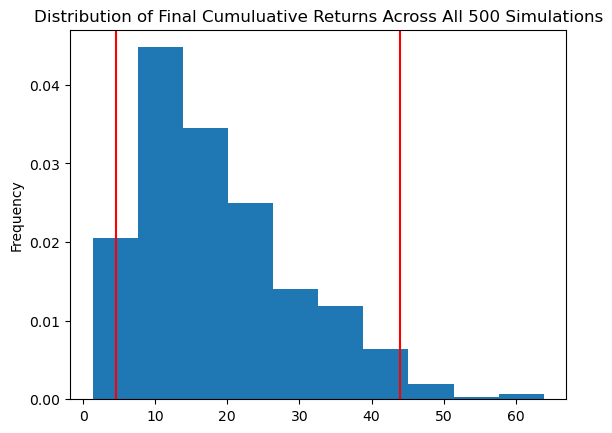

In [211]:
# Plot probability distribution and confidence intervals
port_forecast.plot_distribution()

### Retirement Analysis

In [215]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = port_forecast.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean             18.557197
std              10.778457
min               1.352711
25%               9.988807
50%              15.967643
75%              24.628560
max              63.884705
95% CI Lower      4.605345
95% CI Upper     44.017091
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [217]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $92106.91 and $880341.83


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [226]:
# Set initial investment
initial_investment_expected = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower_expected = round(tbl[8]*initial_investment_expected,2)
ci_upper_expected = round(tbl[9]*initial_investment_expected,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_expected} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_expected} and ${ci_upper_expected}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $138160.36 and $1320512.74


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [220]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
num_sims= 500

port_forecast_5y = MCSimulation(
    portfolio_data = df_stock_data,
    num_simulation = num_sims,
    weights = [0.2, 0.8],
    num_trading_days = (252*5)
)

In [221]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
port_forecast_5y.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/petertran/Fintec/Module Challenge/API_Challenge/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006637,1.005904,0.991658,1.000381,0.986995,1.002819,0.998464,0.990219,0.989319,1.016281,...,0.995006,1.003337,1.004139,1.010943,0.994450,0.997298,0.992153,1.003115,0.999009,1.003055
2,1.015822,1.010147,0.998294,1.010991,0.987858,1.007183,1.015731,0.995684,1.002050,1.011372,...,1.001041,1.022016,0.997999,1.026138,0.997732,0.990332,0.995968,1.003248,1.005217,1.002509
3,1.029709,1.016537,0.998354,0.999282,0.990873,1.038756,1.003141,0.997747,0.989881,1.001218,...,1.001947,1.026055,1.006850,1.030199,0.991903,0.986769,0.991152,1.009188,0.987971,0.991346
4,1.012282,1.015074,1.004516,0.989183,0.994483,1.045883,0.994531,1.013785,0.989700,1.006619,...,0.989906,1.022893,1.013563,1.035710,0.990192,0.999533,1.009505,1.007941,1.001392,1.000102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.301682,1.270758,2.377689,1.474940,2.811264,1.129781,1.702146,1.622254,1.190931,1.629381,...,1.331885,1.652313,3.509127,1.276846,1.487194,2.204325,2.684371,1.055097,2.776328,1.447133
1257,1.298215,1.262088,2.381396,1.474016,2.799089,1.104037,1.717004,1.623023,1.173376,1.605083,...,1.335907,1.649945,3.525141,1.292524,1.473805,2.179986,2.712677,1.038179,2.803613,1.429974
1258,1.283988,1.246426,2.398098,1.470309,2.741474,1.108239,1.710966,1.629553,1.187484,1.603245,...,1.341423,1.645330,3.514917,1.284994,1.472679,2.183925,2.655829,1.039066,2.797812,1.429223
1259,1.280358,1.240519,2.397687,1.468363,2.748750,1.111047,1.704860,1.617576,1.187725,1.592447,...,1.338930,1.641214,3.545691,1.275933,1.469653,2.188414,2.648001,1.053153,2.788127,1.432896


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

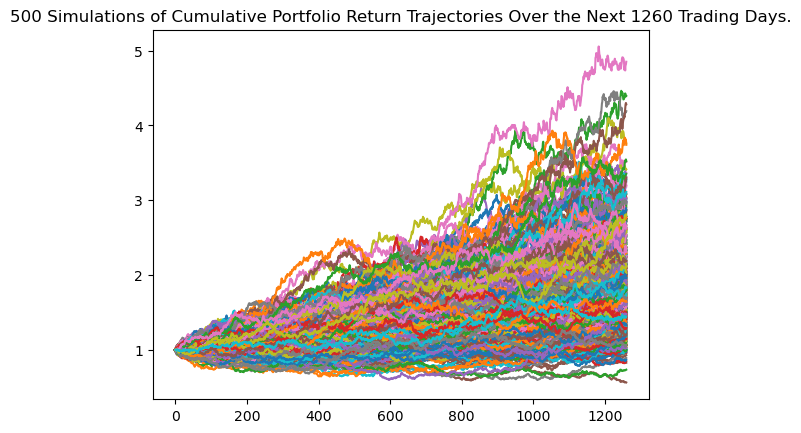

In [222]:
# Plot simulation outcomes
port_forecast_5y.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

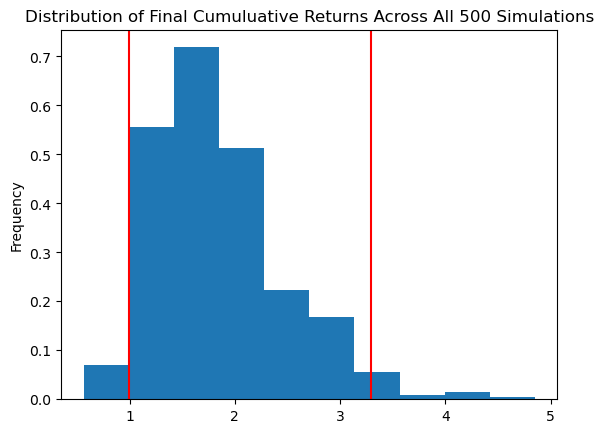

In [223]:
# Plot probability distribution and confidence intervals
port_forecast_5y.plot_distribution()

In [225]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_5y = port_forecast_5y.summarize_cumulative_return()

# Print summary statistics
print(tbl_5y)

count           500.000000
mean              1.848879
std               0.625497
min               0.565388
25%               1.403992
50%               1.739051
75%               2.159738
max               4.850663
95% CI Lower      0.988881
95% CI Upper      3.295395
Name: 1260, dtype: float64


In [229]:
# Set initial investment
initial_investment_5y = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_5y = round(tbl_5y[8]*initial_investment_5y,2)
ci_upper_5y = round(tbl_5y[9]*initial_investment_5y,2)


# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5y} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_5y} and ${ci_upper_5y}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $59332.89 and $197723.68


### Ten Years Retirement Option

In [233]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
port_forecast_10y = MCSimulation(
    portfolio_data = df_stock_data,
    num_simulation = num_sims,
    weights = [0.2, 0.8],
    num_trading_days = (252*10)
)

In [234]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
port_forecast_10y.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/petertran/Fintec/Module Challenge/API_Challenge/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997351,1.010715,0.996153,0.985679,1.010874,0.995323,0.987926,1.013960,1.002687,1.001297,...,0.997290,0.996876,1.001606,1.015794,0.993019,1.004976,1.014964,1.010142,1.011797,0.994948
2,0.976099,0.994639,1.004479,0.988990,1.001935,0.979035,0.995302,1.017717,0.991063,1.000909,...,1.007775,0.989540,0.993464,1.024888,1.001576,1.018995,1.024081,1.027533,1.000731,1.003260
3,0.975117,0.992368,0.995471,0.989168,0.993637,0.958382,0.987273,1.007945,0.997197,1.002778,...,0.997435,0.986172,0.988279,1.014960,0.991790,1.019285,1.024207,1.029262,1.006005,1.002500
4,0.972088,0.994713,1.000346,0.978150,0.983146,0.972789,1.000779,1.009280,0.984099,0.998156,...,0.987177,0.993251,0.983513,1.022794,1.015012,1.033130,1.022097,1.033469,1.007370,0.994183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.625227,2.973483,4.137769,2.500861,7.634439,3.385013,3.459811,3.909270,2.499205,4.042126,...,4.405089,1.819979,2.932861,4.607622,3.101769,4.581451,2.309104,4.428943,4.324041,4.065106
2517,1.634042,3.001543,4.179577,2.500221,7.548000,3.374556,3.518818,3.949108,2.478381,4.062323,...,4.527516,1.831576,2.969492,4.643084,3.109802,4.584153,2.280545,4.453526,4.288704,4.122084
2518,1.644149,3.024007,4.185852,2.496098,7.578882,3.362283,3.522694,3.944584,2.475107,4.109857,...,4.554376,1.830043,2.962217,4.662171,3.106795,4.575720,2.287676,4.424449,4.258795,4.079160
2519,1.632286,2.970093,4.135108,2.478314,7.513437,3.317099,3.545595,3.917621,2.470264,4.160557,...,4.559925,1.834487,2.957927,4.692362,3.132169,4.620588,2.279428,4.454623,4.276041,3.997086


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

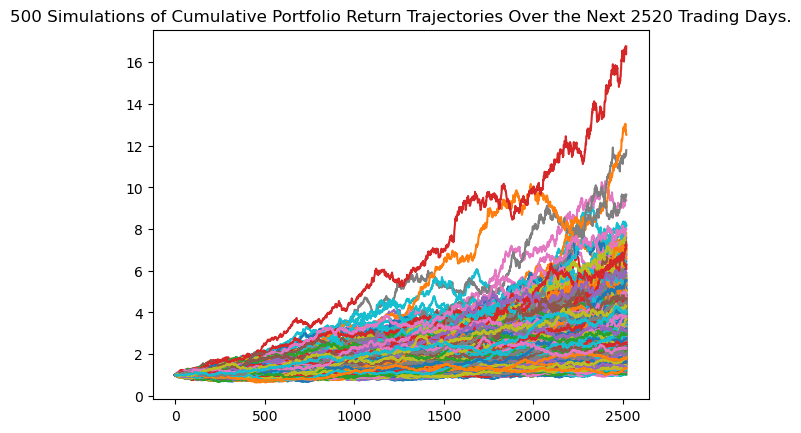

In [235]:
# Plot simulation outcomes
port_forecast_10y.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

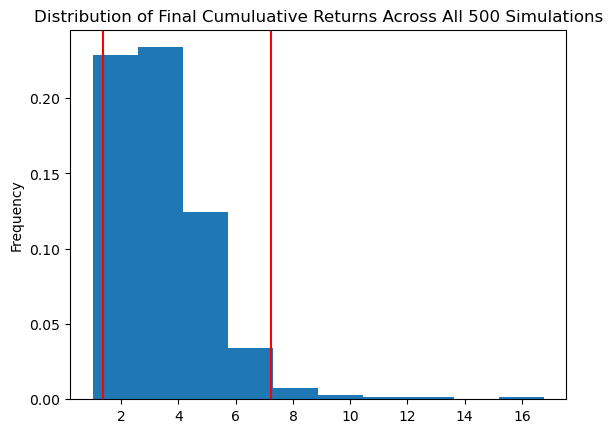

In [236]:
# Plot probability distribution and confidence intervals
port_forecast_10y.plot_distribution()

In [239]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_10y = port_forecast_10y.summarize_cumulative_return()

# Print summary statistics
print(tbl_10y)

count           500.000000
mean              3.437387
std               1.689454
min               1.011571
25%               2.280200
50%               3.082719
75%               4.250338
max              16.757842
95% CI Lower      1.380536
95% CI Upper      7.221307
Name: 2520, dtype: float64


In [240]:
# Set initial investment
initial_investment_10y = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_10y = round(tbl_10y[8]*initial_investment_10y,2)
ci_upper_10y = round(tbl_10y[9]*initial_investment_10y,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10y} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_10y} and ${ci_upper_10y}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $82832.14 and $433278.45
